<h1 style="font-size: 30px; color:turquoise;">Generative Adversarial Network (GAN) on the CIFAR10-Dataset using Tensorflow</h1>
<h2 style="font-size: 20px;">Authors: Bruno Figura & Daniel Labuda, ML II Projektarbeit Gruppe 2, SoSe24</h2>
-----------------------------------------------------------------------------------------------------


In [1]:
#Import all necessary libraries. Libraries can be found in the gan_requirements.txt
import os
import sys
import PIL
import time
import glob
import imageio
import numpy as np
from IPython import display
from datetime import datetime
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm
from scipy.stats import entropy

import keras
import tensorflow as tf
from keras.models import Model
from keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Print Python environment information
print(sys.prefix, sys.version, "\n")

# Ensure the relevant folders exist
if not os.path.exists('CIFAR10_gif'):
    os.makedirs('CIFAR10_gif')

if not os.path.exists('CIFAR10_backups'):
    os.makedirs('CIFAR10_backups')

c:\Users\bruno\Documents\ML2-Projekt\mlClasssificationGan\.venv 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)] 



In [2]:
# Ensure TensorFlow is set up to use the GPU if available
gpus = tf.config.list_physical_devices('GPU')
print("List of GPUs:",gpus)
if gpus:
    print("GPU is available and will be used for generation.")
    device_name = '/GPU:0'
    print("CUDA Support:", tf.test.is_built_with_cuda())
else:
    print("GPU is not available. Ensure you have a compatible GPU and TensorFlow setup.")
    device_name = '/CPU:0'

List of GPUs: []
GPU is not available. Ensure you have a compatible GPU and TensorFlow setup.


Import & prep dataset

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step
Training data shape:
 (50000, 32, 32, 3) 

Test data shape:
 (10000, 32, 32, 3) 

Training labels shape:
 (50000, 10) 

Test labels shape:
 (10000, 10)


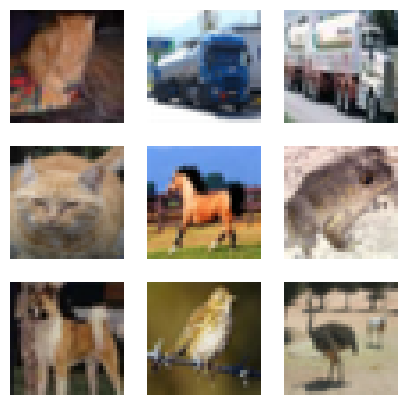

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Import & prep dataset
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

print("Training data shape:\n", train_data.shape, "\n")
print("Test data shape:\n", test_data.shape, "\n")

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_data = (train_data - 127.5) / 127.5  # Normalize the images to [-1, 1]
test_data = (test_data - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

print("Training labels shape:\n", train_labels.shape, "\n")
print("Test labels shape:\n", test_labels.shape)

BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

random_indices = np.random.choice(train_data.shape[0], 9, replace=False)
random_images = train_data[random_indices]

plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((random_images[i] * 127.5 + 127.5).astype(np.uint8))
    plt.axis('off')
plt.show()

c:\Users\bruno\Documents\ML2-Projekt\mlClasssificationGan\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │       206,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 3)      │         1,731 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 578,819 (2.21 MB)

 Trainable params: 578,179 (2.21 MB)

 Non-trainable params: 640 (2.50 KB)

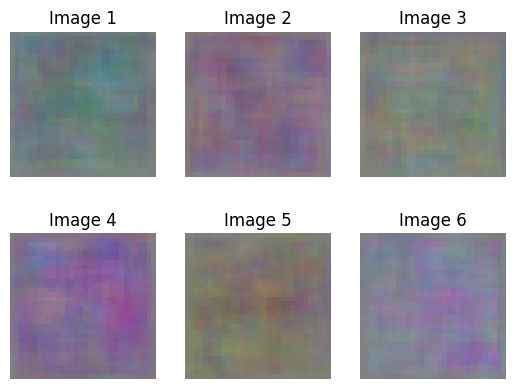

In [5]:
#Source for generator and discriminator models (DCGAN): https://doi.org/10.1007/s11042-019-08600-2
#One extra layer added

def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(128 * 4 * 4, activation="relu", input_shape=(100,)))
    model.add(layers.Reshape((4, 4, 128)))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.Conv2D(3, kernel_size=3, padding="same"))
    model.add(layers.Activation("tanh"))

    return model

generator = make_generator_model()
generator.summary()

print("\n\n\n")

for i in range(6):
    noise = tf.random.normal([1, 100])
    generator = make_generator_model()
    generated_image = generator(noise, training=False)

    plt.subplot(2, 3, i + 1)
    plt.imshow((generated_image[0, :, :, :].numpy() * 127.5 + 127.5).astype(np.uint8))
    plt.title(f"Image {i+1}")
    plt.axis('off')
plt.show()

Discriminator: Hier kann ein aufwändiges CNN rein. 

In [6]:
#Builds on the MNIST model
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(16, kernel_size=3, strides=2, input_shape=[32, 32, 3], padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding="same"))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

decision = discriminator(generated_image)
print("\n\n\n")
print (decision)

c:\Users\bruno\Documents\ML2-Projekt\mlClasssificationGan\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\bruno\Documents\ML2-Projekt\mlClasssificationGan\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 9, 9, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 5, 5, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │         6,401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,929 (1.53 MB)

 Trainable params: 399,969 (1.53 MB)

 Non-trainable params: 960 (3.75 KB)





tf.Tensor([[0.50015604]], shape=(1, 1), dtype=float32)


In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)


noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    generator_losses = []
    discriminator_losses = []
    #accuracy_rates = []

    for epoch in range(epochs):
        start = time.time()
        print(f'Epoch {epoch + 1}/{epochs}')

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            generator_losses.append(gen_loss)
            discriminator_losses.append(disc_loss)

        # Produce images and plot losses at the end of each epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        plot_loss(generator_losses, discriminator_losses, epoch + 1)
        print('Time for epoch {} is {:.1f} sec'.format(epoch + 1, time.time()-start))

    # Generate and plot images after the final epoch 
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    plot_loss(generator_losses, discriminator_losses, epochs)

    print('Generator loss after {} epochs: {:.2f}'.format(epoch+1, gen_loss))
    print('Discriminator loss after {} epochs: {:.2f}'.format(epoch+1, disc_loss))
    
def plot_loss(generator_losses, discriminator_losses, epoch):
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Generator and Discriminator Losses')
    plt.legend()
    plt.savefig('losses_gan_cifar10.svg', format='svg', bbox_inches='tight')
    plt.show()

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #print(type(predictions[i, :, :, :]))
        plt.imshow((predictions[i, :, :, :].numpy() * 127.5 + 127.5).astype(np.uint8))
        plt.axis('off')

    plt.savefig('CIFAR10_gif/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

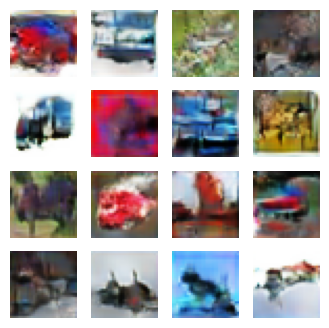

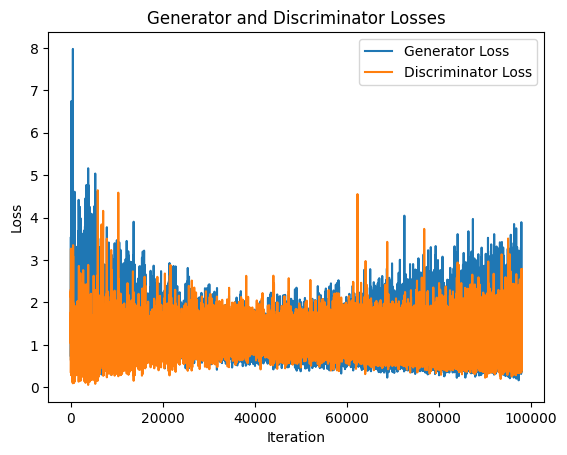

Generator loss after 500 epochs: 1.56
Discriminator loss after 500 epochs: 2.79


In [8]:
EPOCHS = 500

train(train_dataset, EPOCHS)

# Backup the generator and discriminator models
generator.save('CIFAR10_backups/CIFAR10_generator_model_{}epochs_backup_{}.keras'.format(EPOCHS, datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))
discriminator.save('CIFAR10_backups/CIFAR10_discriminator_model_{}epochs_backup_{}.keras'.format(EPOCHS, datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))

# Save the generator model for further processing
generator.save('CIFAR10_generator_model_{}epochs.keras'.format(EPOCHS))

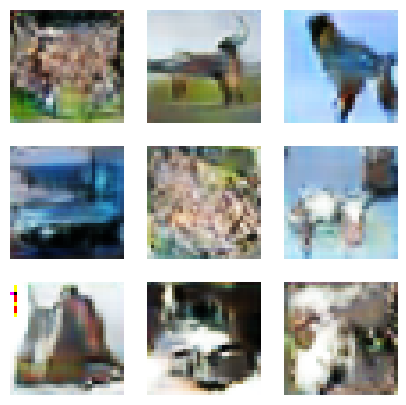

In [10]:
# Load generator from folder
generator = tf.keras.models.load_model('CIFAR10_backups/CIFAR10_generator_model_500epochs_backup_2024-06-19_07-27-42.keras')

# Define the number of new CIFAR-10 images to generate
n = 50  # You can change this number as needed

# Generate images from the noise
random_noise = tf.random.normal([n, noise_dim])
generated_images = generator(random_noise, training=False)

# Rescale the images from [-1, 1] to [0, 1]
generated_images = (generated_images + 1) / 2.0
generated_images = generated_images.numpy()

random_indices = np.random.choice(generated_images.shape[0], 9, replace=False)
random_images = generated_images[random_indices]

# Plot the random images
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((random_images[i] * 256).astype(np.uint8))
    plt.axis('off')
plt.show()

In [11]:
# Function to calculate accuracy rate
def calculate_accuracy_rate(generator, discriminator, num_samples=7500):
    # Generate a batch of real and fake images
    real_images = train_data[:num_samples]
    noise = tf.random.normal([num_samples, noise_dim])
    fake_images = generator(noise, training=False)

    # Get discriminator predictions
    real_predictions = discriminator(real_images, training=False)
    fake_predictions = discriminator(fake_images, training=False)

    # Calculate accuracy and error rate
    real_labels = tf.ones_like(real_predictions)
    fake_labels = tf.zeros_like(fake_predictions)

    real_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(real_predictions), real_labels), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(fake_predictions), fake_labels), tf.float32))

    accuracy_rate = (real_accuracy + fake_accuracy) / 2.0

    return accuracy_rate.numpy()

# Calculate accuracy rate and error rate
accuracy_rate = calculate_accuracy_rate(generator, discriminator)

print(f"Accuracy Rate: {accuracy_rate:.4f}")

Accuracy Rate: 0.6930
